#### Transaction Details Module


In [1]:
# set Spark Session
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext 


spark = SparkSession.builder \
    .appName("PySpark MySQL Connection") \
    .config("spark.jars", "./mysql-connector-java-8.0.23.jar") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

23/10/13 08:19:04 WARN Utils: Your hostname, Irinas-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.125 instead (on interface en0)
23/10/13 08:19:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/10/13 08:19:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [47]:
# Set the JDBC URL and table name
url='jdbc:mysql://localhost:3306/creditcard_capstone'

# Path to your MySQL JDBC connector JAR
mysql_jar_path = "./mysql-connector-java-8.0.23.jar"

import os 
file_path = "./secret.txt"  # Replace with the actual path

# Read the file and extract credentials
credentials = {}
with open(file_path, 'r') as file:
    for line in file:
        key, value = line.strip().split(': ')
        credentials[key] = value

# Access the credentials
mypass = credentials.get('MYPASS')
mylogin = credentials.get('MYLOGIN')

# Set the properties including user and password
properties = {
    "user": mylogin,
    "password": mypass,
    "driver": "com.mysql.jdbc.Driver"
}

customer_mySQL = 'creditcard_capstone.CDW_SAPP_CUSTOMER'
credit_mySQL = 'creditcard_capstone.CDW_SAPP_CREDIT_CARD'
branch_mySQL = 'creditcard_capstone.CDW_SAPP_BRANCH'
loan_mySQL = 'creditcard_capstone.CDW_SAPP_loan_application'

In [49]:
# Read Tables from MySQLData base
df_customer = spark.read.jdbc(url, customer_mySQL, properties=properties)
df_credit = spark.read.jdbc(url, credit_mySQL, properties=properties)
df_branch = spark.read.jdbc(url, branch_mySQL, properties=properties)
df_loan = spark.read.jdbc(url, loan_mySQL, properties=properties)

In [4]:
df_customer.columns

['CREDIT_CARD_NO',
 'CUST_CITY',
 'CUST_COUNTRY',
 'CUST_EMAIL',
 'CUST_PHONE',
 'CUST_STATE',
 'CUST_ZIP',
 'FIRST_NAME',
 'LAST_NAME',
 'LAST_UPDATED',
 'MIDDLE_NAME',
 'SSN',
 'FULL_STREET_ADDRESS']

In [5]:
df_credit.columns

['BRANCH_CODE',
 'CUST_SSN',
 'DAY',
 'MONTH',
 'TRANSACTION_ID',
 'TRANSACTION_TYPE',
 'TRANSACTION_VALUE',
 'YEAR',
 'CUST_CC_NO',
 'TIMEID']

In [7]:
# Create a TempTables 
df_customer.createOrReplaceTempView('customer')
df_credit.createOrReplaceTempView('credit')
df_branch.createOrReplaceTempView('branch')

In [8]:
spark.sql('Select * from credit limit 3').show()

+-----------+---------+---+-----+--------------+----------------+-----------------+----+----------------+--------+
|BRANCH_CODE| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|      CUST_CC_NO|  TIMEID|
+-----------+---------+---+-----+--------------+----------------+-----------------+----+----------------+--------+
|        156|123455692| 13|   08|         22562|         Grocery|            91.08|2018|4210653312478046|20180813|
|        180|123451310| 15|   03|         45069|           Bills|            77.79|2018|4210653342242023|20180315|
|        114|123455692| 26|   06|         22563|           Bills|             22.2|2018|4210653312478046|20180626|
+-----------+---------+---+-----+--------------+----------------+-----------------+----+----------------+--------+




1)    Used to display the transactions made by customers living in a given zip code 
for a given month and year. Order by day in descending order.
2)    Used to display the number and total values of transactions for a given type.
3)    Used to display the total number and total values of transactions for branches in a given state.

In [9]:
# # 1)    Used to display the transactions made by customers living in a given zip code for a given month and year. Order by day in descending order.
zip = '19438'
year = '2018'
month = '08'
query_transaction_zip = f"select TRANSACTION_ID, \
                            TRANSACTION_VALUE, \
                            TRANSACTION_TYPE, \
                            TIMEID, \
                            FIRST_NAME, \
                            LAST_NAME, \
                            CUST_ZIP, \
                            YEAR, \
                            MONTH \
                            from credit t \
                            left join customer c \
                            on t.CUST_SSN = c.SSN \
                            where c.cust_zip = {zip} \
                            and t.YEAR = {year} and t.MONTH = {month}"

In [10]:
result_transaction_by_zip = spark.sql(query_transaction_zip)


In [11]:
result_transaction_by_zip.show()

+--------------+-----------------+----------------+--------+----------+---------+--------+----+-----+
|TRANSACTION_ID|TRANSACTION_VALUE|TRANSACTION_TYPE|  TIMEID|FIRST_NAME|LAST_NAME|CUST_ZIP|YEAR|MONTH|
+--------------+-----------------+----------------+--------+----------+---------+--------+----+-----+
|          7886|            17.83|      Healthcare|20180813| Sylvester|  Padgett|   19438|2018|   08|
|          7877|            42.57|         Grocery|20180802| Sylvester|  Padgett|   19438|2018|   08|
|          7861|            52.45|       Education|20180821| Sylvester|  Padgett|   19438|2018|   08|
|          7860|            38.25|           Bills|20180817| Sylvester|  Padgett|   19438|2018|   08|
|          7849|             8.81|            Test|20180807| Sylvester|  Padgett|   19438|2018|   08|
|          7837|            20.23|   Entertainment|20180813| Sylvester|  Padgett|   19438|2018|   08|
|            92|            58.25|       Education|20180803|    Amalia|   Campos| 

In [12]:
# 2)    Used to display the number and total values of transactions for a given type.

trans_type = spark.sql('Select distinct TRANSACTION_TYPE from credit')
trans_type.show()

+----------------+
|TRANSACTION_TYPE|
+----------------+
|       Education|
|   Entertainment|
|      Healthcare|
|         Grocery|
|            Test|
|             Gas|
|           Bills|
+----------------+



In [13]:
type(trans_type)

pyspark.sql.dataframe.DataFrame

In [14]:
# Collect the distinct TRANSACTION_TYPE values into a list
trans_type_list = trans_type.rdd.map(lambda row: row[0]).collect()

# Print the list
print(trans_type_list)

Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=23200Kb max_used=23657Kb free=107871Kb
 bounds [0x00000001089d8000, 0x000000010a118000, 0x00000001109d8000]
 total_blobs=9405 nmethods=8435 adapters=883
 compilation: disabled (not enough contiguous free space left)
['Education', 'Entertainment', 'Healthcare', 'Grocery', 'Test', 'Gas', 'Bills']


In [15]:
transaction_type = 'Education'
query_total_by_type = f"select TRANSACTION_TYPE, round(sum(TRANSACTION_VALUE), 2) as total_value \
    from credit \
    where TRANSACTION_TYPE = '{transaction_type}' \
    group by TRANSACTION_TYPE"

In [16]:
result_total_by_type = spark.sql(query_total_by_type)

In [17]:
result_total_by_type.show()

+----------------+-----------+
|TRANSACTION_TYPE|total_value|
+----------------+-----------+
|       Education|  337980.07|
+----------------+-----------+



In [18]:
# 3)    Used to display the total number and total values of transactions for branches in a given state.

branch_name = spark.sql('select distinct BRANCH_STATE from branch')
branch_name.show()

+------------+
|BRANCH_STATE|
+------------+
|          SC|
|          MN|
|          NJ|
|          VA|
|          KY|
|          MI|
|          WI|
|          CA|
|          CT|
|          MT|
|          NC|
|          MD|
|          IL|
|          WA|
|          MS|
|          AL|
|          IN|
|          OH|
|          IA|
|          PA|
+------------+
only showing top 20 rows



In [19]:
branch_list = branch_name.rdd.map(lambda row: row[0]).collect()

In [20]:
state = 'MA'
query_state = f"select count(t.TRANSACTION_ID), \
        round(sum(t.TRANSACTION_VALUE), 2) \
        from credit t \
        left join branch b \
        on t.BRANCH_CODE = b.BRANCH_CODE \
        where b.BRANCH_STATE = '{state}'"
result_total_count_sum_trans_by_state = spark.sql(query_state).show()

+---------------------+--------------------------------+
|count(TRANSACTION_ID)|round(sum(TRANSACTION_VALUE), 2)|
+---------------------+--------------------------------+
|                  856|                        43131.18|
+---------------------+--------------------------------+



#### Customer Details Module

1) Used to check the existing account details of a customer.
2) Used to modify the existing account details of a customer.
3) Used to generate a monthly bill for a credit card number for a given month and year.
4) Used to display the transactions made by a customer between two dates. Order by year, month, and day in descending order.

In [21]:
spark.sql("Select SSN from customer limit 1").show()

+---------+
|      SSN|
+---------+
|123456100|
+---------+



In [22]:
# 1) Used to check the existing account details of a customer.

ssn_customer = 123456100
query_ssn = f"Select * from customer where SSN = {ssn_customer}"

In [23]:
result_ssn = spark.sql(query_ssn)

In [24]:
result_ssn.show()

+----------------+---------+-------------+-------------------+-------------+----------+--------+----------+---------+-------------------+-----------+---------+--------------------+
|  CREDIT_CARD_NO|CUST_CITY| CUST_COUNTRY|         CUST_EMAIL|   CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|       LAST_UPDATED|MIDDLE_NAME|      SSN| FULL_STREET_ADDRESS|
+----------------+---------+-------------+-------------------+-------------+----------+--------+----------+---------+-------------------+-----------+---------+--------------------+
|4210653310061055| NNatchez|United States|ahooper@example.com|(000)123-7818|        MS|   39120|      Alec|   Hooper|2018-04-21 09:49:02|         wm|123456100|656,Main Street N...|
+----------------+---------+-------------+-------------------+-------------+----------+--------+----------+---------+-------------------+-----------+---------+--------------------+



In [25]:
# 2) Used to modify the existing account details of a customer.

result_ssn.columns

['CREDIT_CARD_NO',
 'CUST_CITY',
 'CUST_COUNTRY',
 'CUST_EMAIL',
 'CUST_PHONE',
 'CUST_STATE',
 'CUST_ZIP',
 'FIRST_NAME',
 'LAST_NAME',
 'LAST_UPDATED',
 'MIDDLE_NAME',
 'SSN',
 'FULL_STREET_ADDRESS']

In [26]:
type(result_ssn.columns)

list

In [27]:
for c in result_ssn.columns:
    print(c)

CREDIT_CARD_NO
CUST_CITY
CUST_COUNTRY
CUST_EMAIL
CUST_PHONE
CUST_STATE
CUST_ZIP
FIRST_NAME
LAST_NAME
LAST_UPDATED
MIDDLE_NAME
SSN
FULL_STREET_ADDRESS


In [50]:
from pyspark.sql.functions import when, col

In [51]:
result_ssn.first()['CUST_EMAIL']

'ahooper@example.com'

In [30]:
# result_ssn_update =
result_ssn_update = result_ssn.withColumn('CUST_EMAIL', when (result_ssn.CUST_EMAIL == (result_ssn.first()['CUST_EMAIL']),'ahooper@example.com').otherwise(result_ssn.CUST_EMAIL))
result_ssn_update.show()

+----------------+---------+-------------+-------------------+-------------+----------+--------+----------+---------+-------------------+-----------+---------+--------------------+
|  CREDIT_CARD_NO|CUST_CITY| CUST_COUNTRY|         CUST_EMAIL|   CUST_PHONE|CUST_STATE|CUST_ZIP|FIRST_NAME|LAST_NAME|       LAST_UPDATED|MIDDLE_NAME|      SSN| FULL_STREET_ADDRESS|
+----------------+---------+-------------+-------------------+-------------+----------+--------+----------+---------+-------------------+-----------+---------+--------------------+
|4210653310061055| NNatchez|United States|ahooper@example.com|(000)123-7818|        MS|   39120|      Alec|   Hooper|2018-04-21 09:49:02|         wm|123456100|656,Main Street N...|
+----------------+---------+-------------+-------------------+-------------+----------+--------+----------+---------+-------------------+-----------+---------+--------------------+



In [31]:
# creditcard_capstone database
import mysql.connector
# creditcard_capstone database

file_path = "./secret.txt"  # Replace with the actual path

# Read the file and extract credentials
credentials = {}
with open(file_path, 'r') as file:
    for line in file:
        key, value = line.strip().split(': ')
        credentials[key] = value

# Access the credentials
mypass = credentials.get('MYPASS')
mylogin = credentials.get('MYLOGIN')

db_connection = mysql.connector.connect(user=mylogin, password=mypass)
db_cursor = db_connection.cursor()


In [32]:
db_cursor.execute("USE creditcard_capstone;")
update_query = f"UPDATE cdw_sapp_customer SET CUST_EMAIL='ahooper@example.com' WHERE SSN={ssn_customer};"
db_cursor.execute(update_query)
db_connection.commit()

In [33]:
spark.sql('Select * from credit limit 3').show()

+-----------+---------+---+-----+--------------+----------------+-----------------+----+----------------+--------+
|BRANCH_CODE| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|      CUST_CC_NO|  TIMEID|
+-----------+---------+---+-----+--------------+----------------+-----------------+----+----------------+--------+
|        156|123455692| 13|   08|         22562|         Grocery|            91.08|2018|4210653312478046|20180813|
|        180|123451310| 15|   03|         45069|           Bills|            77.79|2018|4210653342242023|20180315|
|        114|123455692| 26|   06|         22563|           Bills|             22.2|2018|4210653312478046|20180626|
+-----------+---------+---+-----+--------------+----------------+-----------------+----+----------------+--------+



In [34]:
# 3) Used to generate a monthly bill for a credit card number for a given month and year.
cc_no = 4210653349028689
Y = '2018'
M = '08'
query_monthly_bill  = f'Select * from credit where CUST_CC_NO = {cc_no} and MONTH = {M} and YEAR = {Y} order by DAY asc'

In [35]:
result_monthly_bill = spark.sql(query_monthly_bill)
result_monthly_bill.show(20)

+-----------+---------+---+-----+--------------+----------------+-----------------+----+----------------+--------+
|BRANCH_CODE| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|      CUST_CC_NO|  TIMEID|
+-----------+---------+---+-----+--------------+----------------+-----------------+----+----------------+--------+
|         66|123459988| 03|   08|            92|       Education|            58.25|2018|4210653349028689|20180803|
|         43|123459988| 06|   08|            28|      Healthcare|            98.78|2018|4210653349028689|20180806|
|         23|123459988| 08|   08|             8|             Gas|            95.39|2018|4210653349028689|20180808|
|         59|123459988| 09|   08|            58|           Bills|            13.72|2018|4210653349028689|20180809|
|         63|123459988| 11|   08|            66|       Education|            82.11|2018|4210653349028689|20180811|
|         20|123459988| 13|   08|            22|       Education|              6

In [36]:
print(result_monthly_bill.show(3))

+-----------+---------+---+-----+--------------+----------------+-----------------+----+----------------+--------+
|BRANCH_CODE| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|      CUST_CC_NO|  TIMEID|
+-----------+---------+---+-----+--------------+----------------+-----------------+----+----------------+--------+
|         66|123459988| 03|   08|            92|       Education|            58.25|2018|4210653349028689|20180803|
|         43|123459988| 06|   08|            28|      Healthcare|            98.78|2018|4210653349028689|20180806|
|         23|123459988| 08|   08|             8|             Gas|            95.39|2018|4210653349028689|20180808|
+-----------+---------+---+-----+--------------+----------------+-----------------+----+----------------+--------+
only showing top 3 rows

None


In [37]:
# 4) Used to display the transactions made by a customer 
# between two dates. Order by year, month, and day in descending order.

spark.sql("select * from credit where CUST_SSN =  123459988 and (TIMEID between '20180214' and '20180320') order by TIMEID desc").show()

+-----------+---------+---+-----+--------------+----------------+-----------------+----+----------------+--------+
|BRANCH_CODE| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|      CUST_CC_NO|  TIMEID|
+-----------+---------+---+-----+--------------+----------------+-----------------+----+----------------+--------+
|         35|123459988| 20|   03|             2|   Entertainment|            14.24|2018|4210653349028689|20180320|
|        123|123459988| 20|   03|            62|            Test|            51.91|2018|4210653349028689|20180320|
|        166|123459988| 18|   03|             9|   Entertainment|            93.26|2018|4210653349028689|20180318|
|         44|123459988| 17|   03|            23|           Bills|             7.97|2018|4210653349028689|20180317|
|        156|123459988| 16|   03|            59|      Healthcare|            45.55|2018|4210653349028689|20180316|
|         49|123459988| 16|   03|            76|             Gas|            51.

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

In [39]:
# Group by transaction type and count transactions for each type
transaction_counts = df_credit.groupBy('TRANSACTION_TYPE').count()
# Find the transaction type with the highest transaction count
max_transaction_count = transaction_counts.orderBy('count', ascending=False).first()


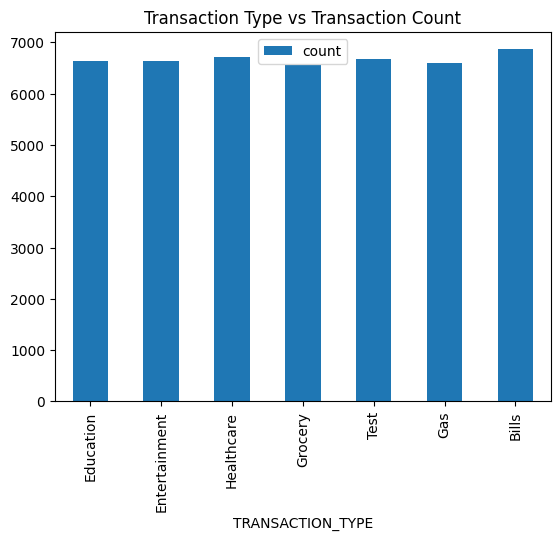

Transaction type with the highest transaction count:
Row(TRANSACTION_TYPE='Bills', count=6861)


In [41]:
# Plot the transaction counts for each type
transaction_counts_pd = transaction_counts.toPandas()
transaction_counts_pd.plot(kind='bar', x='TRANSACTION_TYPE', y='count', 
                               title='Transaction Type vs Transaction Count')
plt.show()

print('Transaction type with the highest transaction count:')
print(max_transaction_count)

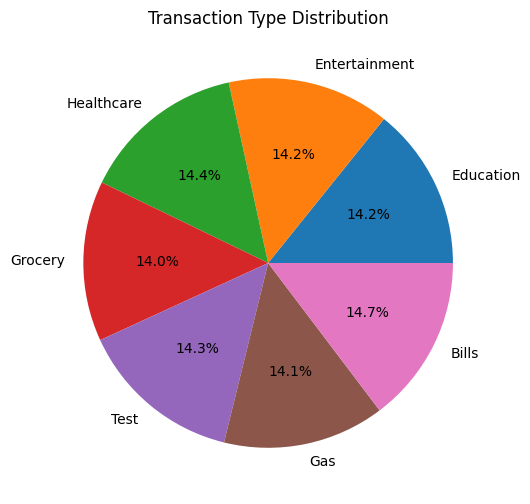

Transaction type with the highest transaction count:
Row(TRANSACTION_TYPE='Bills', count=6861)


In [46]:
# Plot the transaction counts for each type using a pie chart
plt.figure(figsize=(10, 6))
plt.pie(transaction_counts_pd['count'], labels=transaction_counts_pd['TRANSACTION_TYPE'], autopct='%1.1f%%')
plt.title('Transaction Type Distribution')
plt.show()

print('Transaction type with the highest transaction count:')
print(max_transaction_count)

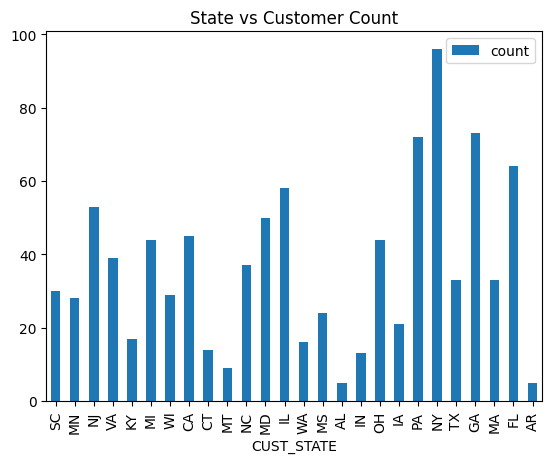

State with the highest number of customers:
Row(CUST_STATE='NY', count=96)


In [43]:

# Group by state and count customers for each state
customer_counts_by_state = df_customer.groupBy('CUST_STATE').count()

# Find the state with the highest number of customers
max_customer_count_state = customer_counts_by_state.orderBy('count', ascending=False).first()

# Plot the number of customers for each state
customer_counts_by_state_pd = customer_counts_by_state.toPandas()
customer_counts_by_state_pd.plot(kind='bar', x='CUST_STATE', y='count', 
                                    title='State vs Customer Count')
plt.show()

print('State with the highest number of customers:')
print(max_customer_count_state)

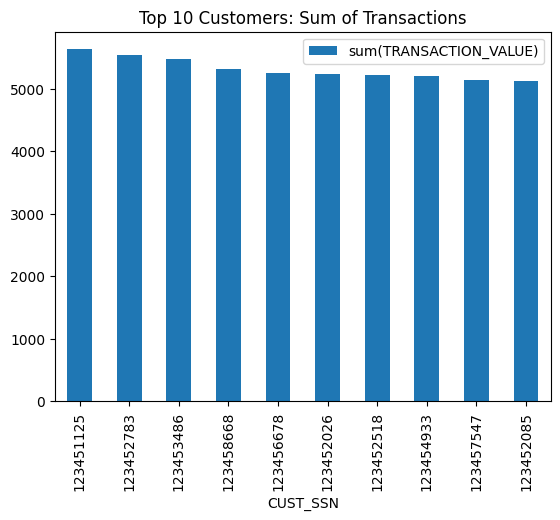

In [44]:
# plot_sum_of_transactions_for_top_10_customers
    # Group by customer SSN and sum the transaction values for each customer
customer_transaction_sum = df_credit.groupBy('CUST_SSN').sum('TRANSACTION_VALUE')

# Sort by transaction sum in descending order
customer_transaction_sum = customer_transaction_sum.orderBy('sum(TRANSACTION_VALUE)', ascending=False)

# Select top 10 customers
top_10_customers = customer_transaction_sum.limit(10)

# Plot the sum of transactions for the top 10 customers
top_10_customers_pd = top_10_customers.toPandas()
top_10_customers_pd.plot(kind='bar', x='CUST_SSN', y='sum(TRANSACTION_VALUE)', 
                            title='Top 10 Customers: Sum of Transactions')
plt.show()

In [45]:
    # Find the customer with the highest transaction amount
customer_highest_transaction = customer_transaction_sum.orderBy('sum(TRANSACTION_VALUE)', 
                                                                    ascending=False).first()

print('Customer with the highest transaction amount:')
print(customer_highest_transaction)

Customer with the highest transaction amount:
Row(CUST_SSN=123451125, sum(TRANSACTION_VALUE)=5633.0700000000015)


In [52]:
# Find and plot the percentage of applications approved for self-employed applicants.
# Calculate the percentage of applications approved for self-employed applicants
self_employed_approval_percentage = df_loan.filter(col("Self_Employed") == "Yes") \
    .groupBy("Application_Status") \
    .count() \
    .withColumn("Percentage", (col("count") / df_loan.count()) * 100) \
    .toPandas()

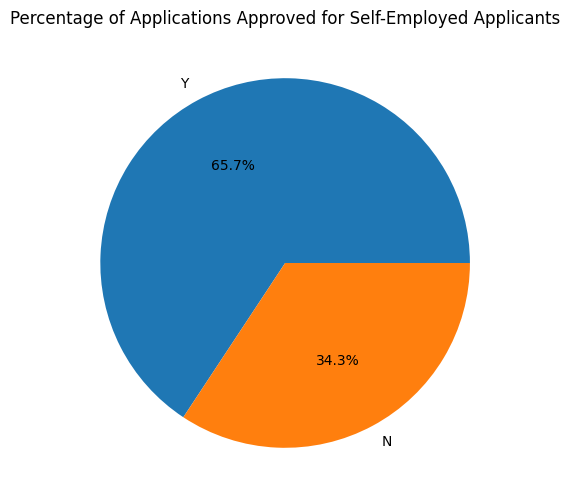

In [53]:
# Plot the percentage of applications approved for self-employed applicants
plt.figure(figsize=(6, 6))
plt.pie(self_employed_approval_percentage['Percentage'], labels=self_employed_approval_percentage['Application_Status'], autopct='%1.1f%%')
plt.title('Percentage of Applications Approved for Self-Employed Applicants')
plt.show()

In [54]:
# Find the percentage of rejection for married male applicants.

# Calculate the percentage of rejection for married male applicants
rejection_percentage_married_male = df_loan.filter((col("Married") == "Yes") & (col("Gender") == "Male") & (col("Application_Status") == "N")) \
    .count()

total_married_male_applicants = df_loan.filter((col("Married") == "Yes") & (col("Gender") == "Male")) \
    .count()

rejection_percentage = (rejection_percentage_married_male / total_married_male_applicants) * 100

print("Percentage of rejection for married male applicants:", rejection_percentage)


Percentage of rejection for married male applicants: 28.431372549019606


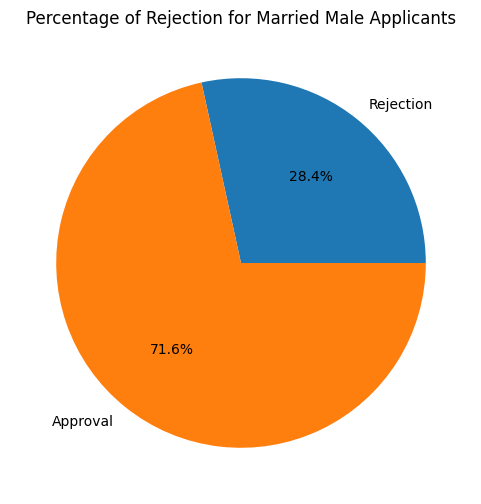

In [55]:
# Plot the percentage of rejection for married male applicants
labels = ['Rejection', 'Approval']
sizes = [rejection_percentage, 100 - rejection_percentage]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Percentage of Rejection for Married Male Applicants')
plt.show()

In [59]:
df_credit.show(3)

+-----------+---------+---+-----+--------------+----------------+-----------------+----+----------------+--------+
|BRANCH_CODE| CUST_SSN|DAY|MONTH|TRANSACTION_ID|TRANSACTION_TYPE|TRANSACTION_VALUE|YEAR|      CUST_CC_NO|  TIMEID|
+-----------+---------+---+-----+--------------+----------------+-----------------+----+----------------+--------+
|        156|123455692| 13|   08|         22562|         Grocery|            91.08|2018|4210653312478046|20180813|
|        180|123451310| 15|   03|         45069|           Bills|            77.79|2018|4210653342242023|20180315|
|        114|123455692| 26|   06|         22563|           Bills|             22.2|2018|4210653312478046|20180626|
+-----------+---------+---+-----+--------------+----------------+-----------------+----+----------------+--------+
only showing top 3 rows



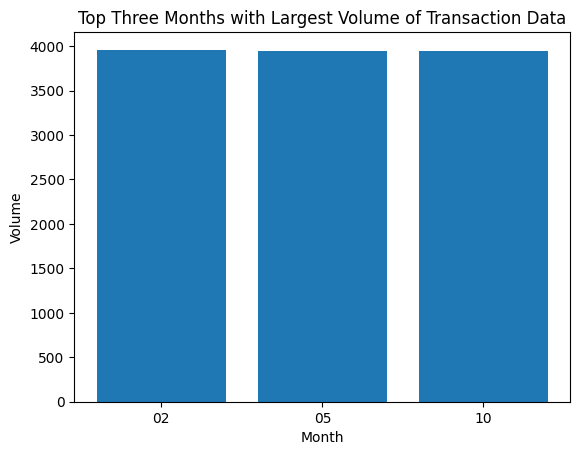

In [64]:
# Find and plot the top three months with the largest volume of transaction data.

from pyspark.sql.functions import count

top_three_months = df_credit.groupBy("MONTH").agg(count("TRANSACTION_ID").alias("transaction_count")) \
    .orderBy("transaction_count", ascending=False).limit(3).toPandas()
# Plot the top three months
plt.bar(top_three_months['MONTH'], top_three_months["transaction_count"])
plt.xlabel('Month')
plt.ylabel('Volume')
plt.title('Top Three Months with Largest Volume of Transaction Data')
plt.show()

In [68]:
df_credit.select('TRANSACTION_TYPE').distinct().show()

+----------------+
|TRANSACTION_TYPE|
+----------------+
|       Education|
|   Entertainment|
|      Healthcare|
|         Grocery|
|            Test|
|             Gas|
|           Bills|
+----------------+



In [74]:
df_credit.printSchema()

root
 |-- BRANCH_CODE: integer (nullable = true)
 |-- CUST_SSN: integer (nullable = true)
 |-- DAY: string (nullable = true)
 |-- MONTH: string (nullable = true)
 |-- TRANSACTION_ID: integer (nullable = true)
 |-- TRANSACTION_TYPE: string (nullable = true)
 |-- TRANSACTION_VALUE: double (nullable = true)
 |-- YEAR: string (nullable = true)
 |-- CUST_CC_NO: string (nullable = true)
 |-- TIMEID: string (nullable = true)



In [87]:
from pyspark.sql.functions import sum, col
from pyspark.sql.types import DoubleType

# Cast "TRANSACTION_VALUE" to double and then perform the aggregation
highest_dollar_value_branch = df_credit \
    .filter(col("TRANSACTION_TYPE") == "Healthcare") \
    .withColumn("TRANSACTION_VALUE", df_credit["TRANSACTION_VALUE"].cast(DoubleType())) \
    .groupBy("BRANCH_CODE") \
    .agg(sum("TRANSACTION_VALUE").alias("dollar_value")) \
    .orderBy(col("dollar_value").desc()) \
    .first()

In [106]:
dollar_value_branch = df_credit \
    .filter(col("TRANSACTION_TYPE") == "Healthcare") \
    .withColumn("TRANSACTION_VALUE", df_credit["TRANSACTION_VALUE"].cast(DoubleType())) \
    .groupBy("BRANCH_CODE") \
    .agg(sum("TRANSACTION_VALUE").alias("dollar_value")) \
    .orderBy(col("dollar_value").desc()).limit(10).toPandas()

In [ ]:
print(highest_dollar_value_branch)

In [116]:
# Extract values
branch_code = highest_dollar_value_branch.BRANCH_CODE
dollar_value = highest_dollar_value_branch.dollar_value

# Print in a formatted way
print(f"Branch Code: {branch_code}")
print(f"Dollar Value: {dollar_value:.2f}")

Branch Code: 25
Dollar Value: 4370.18


In [115]:
print(highest_dollar_value_branch)

Row(BRANCH_CODE=25, dollar_value=4370.179999999999)


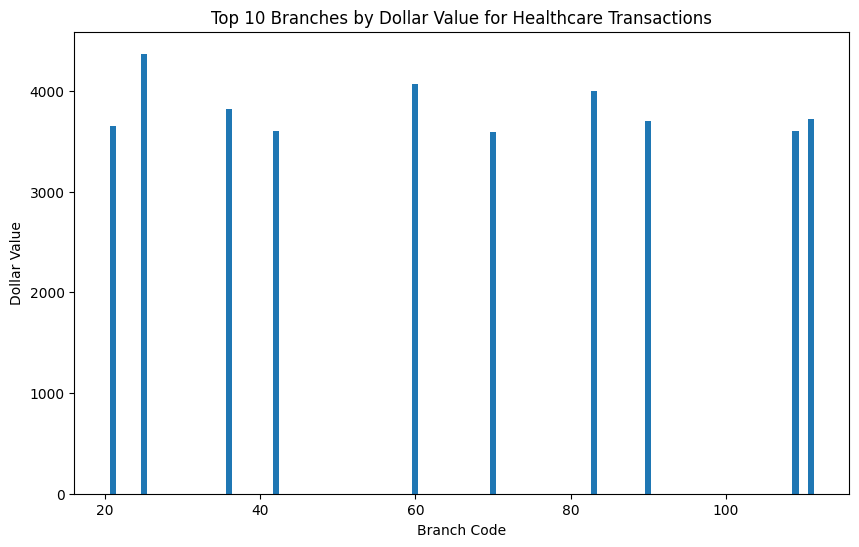

In [112]:
# Plot the data using Matplotlib
plt.figure(figsize=(10, 6))
plt.bar(dollar_value_branch['BRANCH_CODE'], dollar_value_branch['dollar_value'])
plt.xlabel('Branch Code')
plt.ylabel('Dollar Value')
plt.title('Top 10 Branches by Dollar Value for Healthcare Transactions')
plt.show()

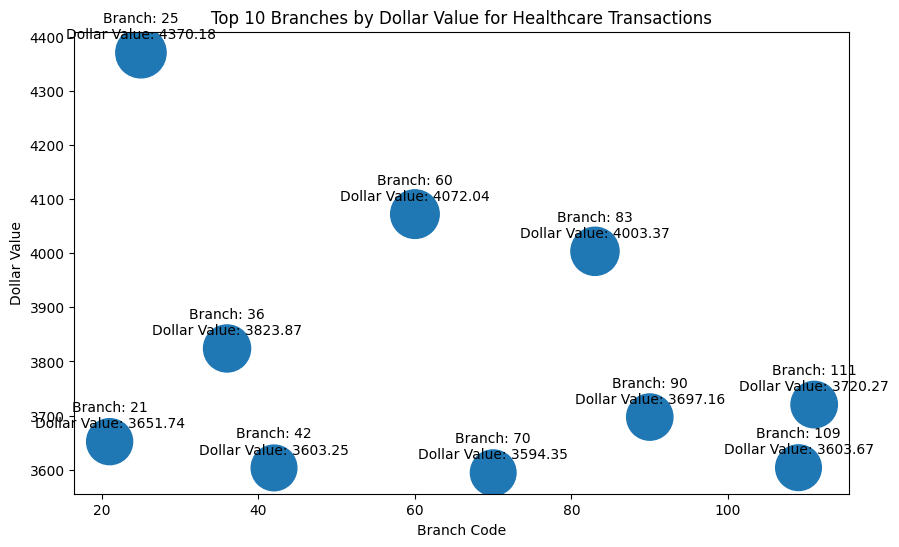

In [122]:
# Plot the data using Matplotlib scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(dollar_value_branch['BRANCH_CODE'], dollar_value_branch['dollar_value'], s=dollar_value_branch['dollar_value']*0.3)  # Adjust the scaling factor as needed
plt.xlabel('Branch Code')
plt.ylabel('Dollar Value')
plt.title('Top 10 Branches by Dollar Value for Healthcare Transactions')

# Annotate each point with branch_code and dollar_value
for i, txt in enumerate(dollar_value_branch['BRANCH_CODE']):
    plt.annotate(f'Branch: {txt}\nDollar Value: {dollar_value_branch["dollar_value"].iloc[i]:.2f}', 
                 (dollar_value_branch['BRANCH_CODE'].iloc[i], dollar_value_branch['dollar_value'].iloc[i]), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center')

plt.show()
plt.show()

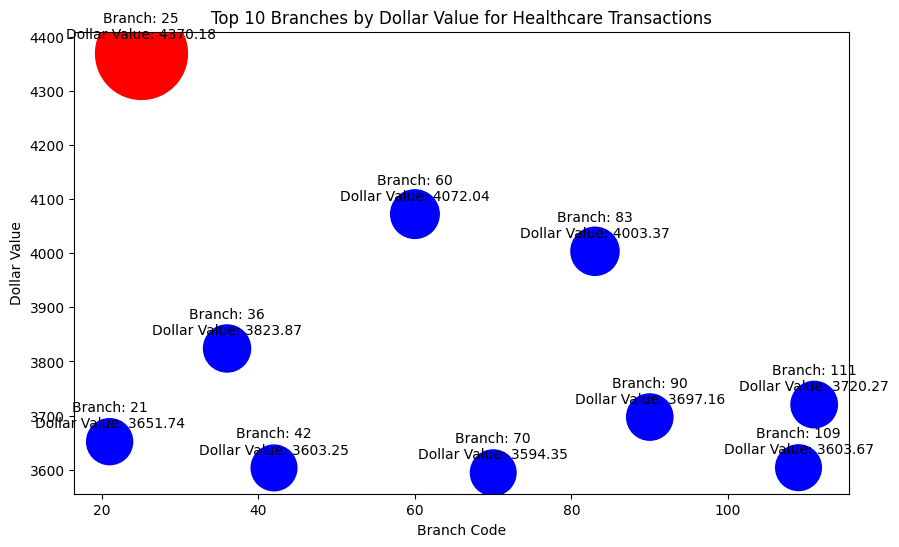

In [126]:


# Find the branch_code with the highest dollar_value
highest_dollar_value = dollar_value_branch['dollar_value'].max()
highest_dollar_value_branch = dollar_value_branch[dollar_value_branch['dollar_value'] == highest_dollar_value]

# Plot the data using Matplotlib scatter plot
plt.figure(figsize=(10, 6))

# Plot all points in blue
plt.scatter(dollar_value_branch['BRANCH_CODE'], dollar_value_branch['dollar_value'], color='blue', s=dollar_value_branch['dollar_value']*0.3)  

# Plot the highest value in red
plt.scatter(highest_dollar_value_branch['BRANCH_CODE'], highest_dollar_value_branch['dollar_value'], color='red', s=highest_dollar_value_branch['dollar_value']*1)  

plt.xlabel('Branch Code')
plt.ylabel('Dollar Value')
plt.title('Top 10 Branches by Dollar Value for Healthcare Transactions')

# Annotate each point with branch_code and dollar_value
for i, txt in enumerate(dollar_value_branch['BRANCH_CODE']):
    plt.annotate(f'Branch: {txt}\nDollar Value: {dollar_value_branch["dollar_value"].iloc[i]:.2f}', 
                 (dollar_value_branch['BRANCH_CODE'].iloc[i], dollar_value_branch['dollar_value'].iloc[i]), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center')

plt.show()

In [127]:
spark.stop()